This is my attempt okay

In [48]:
import face_recognition
import cv2
import numpy as np
import os
import pandas as pd
from datetime import datetime
from IPython.display import display, clear_output
from PIL import Image as PILImage
import time
#import classNames

In [49]:
# Path to the folder containing employee images
path = '/Users/avantika/Desktop/zidio/images'  # Change this to your image folder path
employee_images = {}
employee_ids = []

In [50]:
# Load all images for each employee (images should be in a folder named by employee ID)
for employee_folder in os.listdir(path):
    folder_path = os.path.join(path, employee_folder)
    
    if os.path.isdir(folder_path):  # Ensure it's a folder, not a file
        employee_ids.append(employee_folder)
        employee_images[employee_folder] = []
        
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            employee_images[employee_folder].append(image_path)

classNames = employee_ids

In [51]:

# Function to find encodings of the images and average them per employee
def findEncodings(employee_images):
    known_faces = []
    
    for employee_id, image_paths in employee_images.items():
        employee_encodings = []
        
        for image_path in image_paths:
            img = face_recognition.load_image_file(image_path)
            img_encoding = face_recognition.face_encodings(img)
            
            if img_encoding:  # Only add valid encodings
                employee_encodings.append(img_encoding[0])
        
        # Calculate the average encoding for the employee
        if employee_encodings:
            avg_encoding = np.mean(employee_encodings, axis=0)
            known_faces.append(avg_encoding)
        else:
            print(f"No valid face encodings found for Employee ID: {employee_id}")
    
    return known_faces

In [52]:
# Initialize attendance DataFrame
#attendance_df = pd.DataFrame(columns=['Employee ID', 'Date', 'Time'])


In [53]:
# Mark attendance in the DataFrame
#def markAttendance(employee_id):
#    global attendance_df
#    now = datetime.now()
#   date_string = now.strftime('%Y-%m-%d')
#    time_string = now.strftime('%H:%M:%S')
    
    # Create a DataFrame for the new entry
#    new_entry = pd.DataFrame({'Employee ID': [employee_id], 'Date': [date_string], 'Time': [time_string]})
    
    # Use pd.concat to add the new entry to the existing DataFrame
#    attendance_df = pd.concat([attendance_df, new_entry], ignore_index=True)

In [54]:
# Function to mark entry time
def markAttendanceEntry(employee_id):
    global entry_df
    now = datetime.now()
    
    date_string = now.strftime('%Y-%m-%d')
    time_string = now.strftime('%H:%M:%S')
    new_entry = pd.DataFrame({'Employee ID': employee_id, 'Date': [date_string], 'Entry Time': [time_string]})
    entry_df = pd.concat([entry_df, new_entry], ignore_index=True)
    


In [55]:
# Function to mark exit time
def markAttendanceExit(employee_id):
    global exit_df
    now = datetime.now()
    date_string = now.strftime('%Y-%m-%d')
    time_string = now.strftime('%H:%M:%S')
    
    new_exit = pd.DataFrame({'Employee ID': employee_id, 'Date': [date_string], 'Entry Time': [time_string]})
    exit_df = pd.concat([entry_df, new_exit], ignore_index=True)

In [56]:
# Initialize attendance DataFrames
entry_df = pd.DataFrame(columns=['Employee ID', 'Date', 'Entry Time' ])
exit_df = pd.DataFrame(columns=['Employee ID', 'Date', 'Exit Time' ])

In [57]:
# Encode faces from the images folder
encodeListKnown = findEncodings(employee_images)
print('Encoding complete!')

Encoding complete!


In [71]:
# Initialize webcam
cap = cv2.VideoCapture(0)

In [72]:
# Function to display video frame in Jupyter
def display_frame(frame):
    clear_output(wait=True)  # Clear the previous output to avoid stacking frames
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = PILImage.fromarray(frame_rgb)
    display(pil_img)

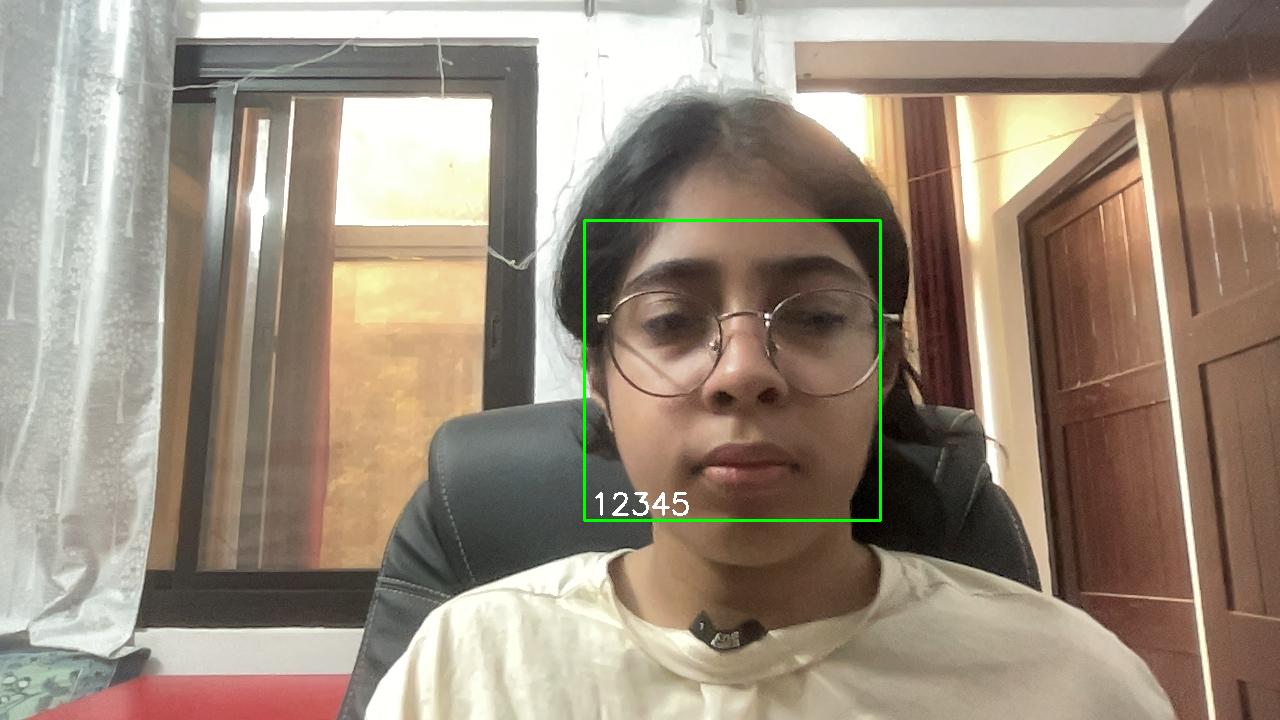

Stopping after 0.5 seconds.


In [76]:
# Set to store IDs of employees whose attendance has been marked
employee_last_seen = {}
# Run face recognition on webcam feed
try:
    start_time = time.time()  # Track the starting time
    frame_count = 0  # Initialize a frame counter
    max_runtime = 0.5
    while True:
        success, img = cap.read()
        if not success:
            print("Failed to capture image from webcam")
            break
        
        imgS = cv2.resize(img, (0, 0), None, 0.25, 0.25)  # Resize for faster processing
        imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)

        # Find faces and encodings in the webcam frame
        facesCurFrame = face_recognition.face_locations(imgS)
        encodesCurFrame = face_recognition.face_encodings(imgS, facesCurFrame)

        current_time = datetime.now()

        for encodeFace, faceLoc in zip(encodesCurFrame, facesCurFrame):
            matches = face_recognition.compare_faces(encodeListKnown, encodeFace)
            faceDis = face_recognition.face_distance(encodeListKnown, encodeFace)

            # Find the best match
            matchIndex = np.argmin(faceDis)

            if matches[matchIndex]:
                employee_id = classNames[matchIndex].upper()

                if employee_id not in employee_last_seen:
                    markAttendanceEntry(employee_id)  # Record entry time
                    employee_last_seen[employee_id] = current_time # Update last seen

                # Detect exit (if the employee has been seen earlier and now they reappear, indicating a leave)
                elif (current_time - employee_last_seen[employee_id]).seconds > 30:  # 5-minute threshold
                    markAttendanceExit(employee_id)  # Record exit time
                    employee_last_seen.pop(employee_id)  # Remove employee from the active list
                    print(f'Employee {employee_id} marked as exiting.')

                # Draw a box around the face
                y1, x2, y2, x1 = faceLoc
                y1, x2, y2, x1 = y1 * 4, x2 * 4, y2 * 4, x1 * 4  # Scale back to original size
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, employee_id, (x1 + 6, y2 - 6), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Update the display every 5 frames to reduce output clutter
        if frame_count % 2 == 0:
            display_frame(img)

        frame_count += 1  # Increment frame counter

        # Check if max runtime is exceeded
        elapsed_time = time.time() - start_time
        if elapsed_time > max_runtime:
            print(f"Stopping after {max_runtime} seconds.")
            break

        # Add a break condition to stop the loop in Jupyter
        key = cv2.waitKey(1)
        if key == ord('q'):
            break

except KeyboardInterrupt:
    print("Interrupted by user")



In [77]:
print(employee_last_seen)
print(entry_df)
print(exit_df)

{'12345': datetime.datetime(2024, 10, 20, 16, 49, 37, 327410)}
  Employee ID        Date Entry Time
0       12345  2024-10-20   16:43:58
1       12345  2024-10-20   16:47:28
2       12345  2024-10-20   16:49:37
Empty DataFrame
Columns: [Employee ID, Date, Exit Time]
Index: []


In [69]:
# Release the webcam
cap.release()
cv2.destroyAllWindows()

In [74]:
entry_df.to_excel('entry_attendance.xlsx', index=False)
exit_df.to_excel('exit_attendance.xlsx', index=False)
print("Attendance data saved to entry_attendance.xlsx and exit_attendance.xlsx")


Attendance data saved to entry_attendance.xlsx and exit_attendance.xlsx


In [75]:
print(employee_last_seen)

{'12345': datetime.datetime(2024, 10, 20, 16, 47, 28, 600543)}
